In [2]:
# ORIGINAL CODE : https://machinelearningmastery.com/weighted-average-ensemble-with-python/
# By Jason Brownlee - MAY 2021

# Modifed by MAHAYASA ADIPUTRA - OCT 2022
import time
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as mt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from numpy import mean
from numpy import std
le = LabelEncoder()
start_time = time.time()
# get the dataset
# Importing the dataset
dataset=pd.read_csv('../../data/dataset2.csv')
dataset=dataset.dropna()
dataset=dataset.fillna(0)

X=dataset.drop(['labels'],axis=1)
y=dataset["labels"]
y = le.fit_transform(y)
#use imblearn SMOTE
smote = SMOTE(random_state=42)
#smote=SVMSMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

#kfold cross validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
 
# get a list of base models
def get_models():
	models = list()
	models.append(('xb', XGBClassifier(colsample_bytree=0.6, max_depth = 5, gamma=1.5, min_child_weight=5)))
#	models.append(('rf', RandomForestClassifier(n_estimators =100, criterion = 'gini', random_state = 0)))
	models.append(('ab', AdaBoostClassifier(n_estimators=100,learning_rate=0.1,algorithm='SAMME.R')))
	return models
 
# evaluate each base model
def evaluate_models(models, X,y):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# evaluate the model
		acc=cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
		# store the performance
		scores.append(mean(acc))
		# report model performance
	return scores



# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X,y)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
score=cross_val_score(ensemble, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Weighted Avg AUC ROC: %.3f' % (mean(score)*100))
print('STD AUC ROC: %.3f' % (std(score)))
print("--- %s seconds ---" % (time.time() - start_time))

[0.989157656979201, 0.9206577427041053]
Weighted Avg AUC ROC: 98.838
STD AUC ROC: 0.001
--- 191.02279376983643 seconds ---


<AxesSubplot:>

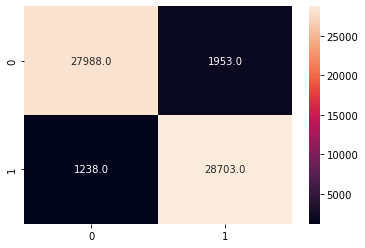

In [11]:
y_pred = cross_val_predict(ensemble, X, y, cv=cv)
import seaborn as sns
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True,fmt=".1f")

In [3]:
pr=cross_val_score(ensemble, X, y, scoring='precision', cv=cv, n_jobs=-1)
mean(pr)

0.9435659005372159

In [4]:
rc=cross_val_score(ensemble, X, y, scoring='recall', cv=cv, n_jobs=-1)
mean(rc)

0.9420675154862345

In [5]:
f1=cross_val_score(ensemble, X, y, scoring='f1', cv=cv, n_jobs=-1)
mean(f1)

0.9427932740065981